In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from PIL import Image
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
import inversefed
from tqdm import tqdm

In [103]:
torch.random.manual_seed(41)
dm = torch.as_tensor(inversefed.consts.cifar10_mean, device='cuda')[:, None, None]
ds = torch.as_tensor(inversefed.consts.cifar10_std, device='cuda')[:, None, None]

In [72]:
loss_fn = nn.CrossEntropyLoss(reduction='mean')

In [2]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv = nn.Sequential(
                nn.Conv2d(3, 24, 5, stride=2, padding=1),
                nn.ReLU(),
                nn.Conv2d(24, 48, 5, stride=2, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(3, stride=1, padding=1)
        )
        self.Flatten = nn.Flatten()
        self.FC = nn.Sequential(
                nn.Linear(2352, 120),
                nn.ReLU(),
                nn.Linear(120, 10)
        )
    
    def forward(self, x):
        y = self.conv(x)
        y = self.Flatten(y)
        y = self.FC(y)
        return y

In [18]:
class Alex_nopool(nn.Module):
    def __init__(self):
        super(Alex_nopool, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 24, 5, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(24, 48, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(3 ,stride=1, padding=1)
        )
        self.Flatten = nn.Flatten()
        self.FC = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.ReLU(),
            nn.Linear(1024, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        x = self.conv(x)
        x = self.Flatten(x)
        return self.FC(x)

In [3]:
class Alex(nn.Module):
    def __init__(self):
        super(Alex, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 24, 5, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=1),
            nn.Conv2d(24, 48, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2)
        )
        self.Flatten = nn.Flatten()
        self.FC = nn.Sequential(
            nn.Linear(1728, 1024),
            nn.ReLU(),
            nn.Linear(1024, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        x = self.conv(x)
        x = self.Flatten(x)
        return self.FC(x)

In [3]:
model = LeNet()
model = model.to('cuda')

In [8]:
trainset = torchvision.datasets.CIFAR10('/mnt/ssd4/weiyang/Dataset/cifar-10-python/', train=True, transform=torchvision.transforms.ToTensor(), download=False)
train_loader = DataLoader(trainset, shuffle=False, batch_size=1)

In [53]:
plt.imsave('images/LeNet_whole/orig_%d.png'%idx, train_loader.dataset[80][0].numpy().transpose(1,2,0))

### Generate Original Gradient

In [135]:
idx = 80
orig, label = train_loader.dataset[idx]
orig, label = orig[None, :].to('cuda'), torch.tensor([label]).to('cuda')
criterion = nn.CrossEntropyLoss()
orig_y = model(orig)
orig_loss = criterion(orig_y, label)
input_gradient = torch.autograd.grad(orig_loss, model.parameters())
input_gradient = [grad.detach() for grad in input_gradient]

In [ ]:
config = dict(signed=True,
              boxed=True,
              cost_fn='sim',
              indices='def',
              weights='equal',
              lr=0.1,
              optim='adam',
              restarts=1,
              max_iterations=24000,
              total_variation=1e-2,
              init='randn',
              filter='none',
              lr_decay=True,
              scoring_choice='loss')

num_images = 1
rec_machine = inversefed.GradientReconstructor(model, (dm, ds), config, num_images=num_images)
output = rec_machine.reconstruct(input_gradient, label, img_shape=(3, 32, 32))
#output, stats = rec_machine.reconstruct(input_gradient, label, img_shape=(3, 32, 32))

#plt.imsave('images/orig%d.png'%idx, orig.cpu().numpy().transpose([0,2,3,1]).squeeze(axis=0))
plt.imsave('images/LeNet_whole/wide_%d.png'%idx, output[0].cpu().numpy().transpose([0,2,3,1]).squeeze(axis=0).clip(0,1))

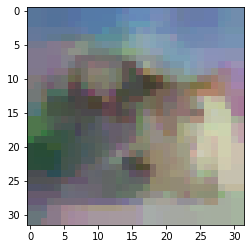

In [46]:
plt.imshow(output[0].cpu().numpy().transpose(0,2,3,1).squeeze(axis=0).clip(0,1))

In [113]:
def rec_fc(input_grad, model, label):
    x_trial = torch.randn((1,2352)).to('cuda')
    optimizer = torch.optim.LBFGS([x_trial])
    for i in range(600):
        def closure():
            optimizer.zero_grad()
            trial_pred = model.FC(x_trial)
            loss = loss_fn(trial_pred, label)
            trial_grad = torch.autograd.grad(loss, model.parameters(), create_graph=True, allow_unused=True)
            grad_loss = 0
            for i in range(4, len(trial_grad)):
                grad_loss += (input_grad[i]-trial_grad[i]).pow(2).sum()
            grad_loss.backward()
            return grad_loss

        optimizer.step(closure)
    return x_trial
    

In [12]:
def rec_x(model, bef_pool):
    x_trial = torch.randn((1,3,32,32)).to('cuda')
    optimizer = torch.optim.LBFGS([x_trial])
    for i in range(600):
        def closure():
            optimizer.zero_grad()
            pred_bef_pool = model.conv[3](model.conv[2](model.conv[1](model.conv[0](x_trial))))
            loss = (pred_bef_pool-bef_pool).pow(2).sum()
            loss.backward(retain_graph = True)
            return loss

        optimizer.step(closure)
    return x_trial

In [114]:
bef_fc = rec_fc(input_gradient, model, label)

In [10]:
bef_pool = model.conv[3](model.conv[2](model.conv[1](model.conv[0](train_loader.dataset[80][0][None, :].to('cuda')))))

In [13]:
rec_x(model, bef_pool)

RuntimeError: Trying to backward through the graph a second time, but the saved intermediate results have already been freed. Specify retain_graph=True when calling .backward() or autograd.grad() the first time.

In [115]:
(model.Flatten(model.conv(orig))-bef_fc).cpu().pow(2).sum()

tensor(2332.5212, grad_fn=<SumBackward0>)

In [ ]:
def cross_pool(aft_pool):
    aft_pool = aft_pool.view(1,32,7,7)
    